In [2]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.discrete.Discrete(3)
        low = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -2, -2, -0.04, -2.828, -70.71], dtype=np.float32)
        high = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2.828, 2.828, 70.71], dtype=np.float32)

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0
        self.distance_t_minus_one = 0
        self.distance_change = 0

        self.out_of_bounds = 0
        self.interceptions = 0
        self.reached_max_steps = 0

        self.defense_positions = []
        self.attack_positions = []

        self.max_steps_per_episode = 150

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_defense()
        self.create_attack(self.defense)
        self.calc_angle(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        # self.graph(self.defense, self.attack)
        self.get_state()

        return self.state, {}

    def create_defense(self):
        x = random.uniform(-0.45, 0.45)
        y = random.uniform(-0.45, 0.45)
        self.defense = np.array([x, y])

    def create_attack(self, defense):
        x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
        x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
        y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
        y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_angle(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.theta = self.theta # 1st quadrant
            else: 
                self.theta = (2*math.pi) - self.theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.theta = math.pi - self.theta # 180 - theta
            else:
                self.theta = math.pi + self.theta # 180 + theta
            
        return self.theta
    
    def initial_missile_angle(self):
        self.missile_angle = np.random.uniform(0, 2*math.pi)
        # if self.theta < math.pi:
        #     self.missile_angle = np.random.uniform(0, math.pi)
        # else:
        #     self.missile_angle = np.random.uniform(math.pi, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.missile_angle)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.missile_angle))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):

        # check if out of bounds
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            self.reward = -1000
            self.done = True
            self.out_of_bounds += 1

        self.missile_distance_to_attack()
        if self.distance < 0:
            self.reward = 1000
            self.done = True
            self.interceptions += 1
        else:
            self.distance_change = ((self.distance - self.distance_t_minus_one) / 0.02) 
            if self.distance_change < 0:
                self.reward = -1 * (self.distance_change * (0.01 + 1/self.distance))
            else:
                self.reward = -5 * (self.distance_change * 1 + 1 * (self.distance**2))

            # angle penalty
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            if self.angle_diff < 0.05:
                self.reward += 0.1
            else:
                self.reward -= (0.1 * self.angle_diff)

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle

    def get_state(self):
        self.angle_conversion()
        self.state = np.array([self.attack[0], self.attack[1], self.defense[0], self.defense[1], self.sin_theta, self.cos_theta, self.sin_missile_angle, self.cos_missile_angle, self.delta_sin, self.delta_cos, self.distance, (self.distance - self.distance_t_minus_one), ((self.distance - self.distance_t_minus_one) / 0.02)])

    def get_state_dict(self):
        return {"reward": self.reward, "attack_x": self.attack[0], "attack_y": self.attack[1], "defense_x": self.defense[0], "defense_y": self.defense[1], "theta": self.theta, "missile_angle": self.missile_angle, "self.sin_theta": self.sin_theta, "self.cos_theta": self.cos_theta, "self.sin_missile_angle": self.sin_missile_angle, "self.cos_missile_angle": self.cos_missile_angle, "delta_sin": self.delta_sin, "delta_cos": self.delta_cos, "distance": self.distance}
                 
    def step(self, action):
        if self.current_step >= self.max_steps_per_episode:
            self.done = True
            self.reward = -100
            self.reached_max_steps += 1

        self.distance_t_minus_one = self.distance
        self.missile_nav_angle(action)
        self.missle_coord_calc()
        self.calculate_reward()
        self.current_step += 1
        self.get_state()

        # self.graph(self.defense, self.attack)

        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')

        ax.set_aspect('equal')
        plt.show()

In [33]:
def run_episode(env, model):
    # If you have only one environment wrapped, you can directly access it
    single_env = env.envs[0]
    obs = env.reset()
    done = False
    total_reward = 0
    step = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        step += 1
    
    # Now access the specific attributes from the single_env which is your actual missile_interception instance
    return step, total_reward, single_env.out_of_bounds, single_env.interceptions, single_env.reached_max_steps



# Create the environment
env = make_vec_env(lambda: missile_interception(), n_envs=1)

# Create the model
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./dqn_missile_interception_logs_v2")

# Create a summary writer
summary_writer = tf.summary.create_file_writer('./dqn_missile_interception_logs_v2/custom_metrics')

# Training loop
total_timesteps = 1000000
eval_interval = 10000  # Evaluate and log every 10000 steps

for step in range(0, total_timesteps, eval_interval):
    # Train for a number of timesteps
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    
    # Run an evaluation episode
    episode_length, episode_reward, out_of_bounds, interceptions, reached_max_steps = run_episode(env, model)
    
    # Log the results
    with summary_writer.as_default():
        tf.summary.scalar('Evaluation/Episode Length', episode_length, step=step)
        # Ensure episode_reward and other metrics are scalars by using .item() if they are numpy arrays or tensors
        tf.summary.scalar('Evaluation/Episode Reward', episode_reward.item() if isinstance(episode_reward, np.ndarray) else episode_reward, step=step)
        tf.summary.scalar('Evaluation/Out of Bounds Count', out_of_bounds.item() if isinstance(out_of_bounds, np.ndarray) else out_of_bounds, step=step)
        tf.summary.scalar('Evaluation/Interceptions Count', interceptions.item() if isinstance(interceptions, np.ndarray) else interceptions, step=step)
        tf.summary.scalar('Evaluation/Reached Max Steps Count', reached_max_steps.item() if isinstance(reached_max_steps, np.ndarray) else reached_max_steps, step=step)
        summary_writer.flush()


# Save the final model
model.save("dqn_missile_interception")

Using cpu device
Logging to ./dqn_missile_interception_logs_v2\DQN_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 69.5     |
|    ep_rew_mean      | -370     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2089     |
|    time_elapsed     | 0        |
|    total_timesteps  | 278      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.44     |
|    n_updates        | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 81.9     |
|    ep_rew_mean      | -478     |
|    exploration_rate | 0.378    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1889     |
|    time_elapsed     | 0        |
|    total_timesteps  | 655      |
| train/              |          |
|    learning_rate   

STEP REWARD:  0.17588148419912625
EPISODE REWARD:  0.17588148419912625
STEP REWARD:  0.45070983692478156
EPISODE REWARD:  0.6265913211239078
STEP REWARD:  0.7258328941047049
EPISODE REWARD:  1.3524242152286128
STEP REWARD:  1.0001964007170439
EPISODE REWARD:  2.3526206159456566
STEP REWARD:  1.2719821163488114
EPISODE REWARD:  3.624602732294468
STEP REWARD:  1.5382125537803444
EPISODE REWARD:  5.162815286074812
STEP REWARD:  1.5575806662906424
EPISODE REWARD:  6.720395952365454
STEP REWARD:  1.5741577624740788
EPISODE REWARD:  8.294553714839532
STEP REWARD:  1.587215910726181
EPISODE REWARD:  9.881769625565713
STEP REWARD:  1.8820405049847486
EPISODE REWARD:  11.763810130550462
STEP REWARD:  2.167109048874716
EPISODE REWARD:  13.930919179425178
STEP REWARD:  2.531997291007326
EPISODE REWARD:  16.462916470432504
STEP REWARD:  2.748563362890172
EPISODE REWARD:  19.211479833322677
STEP REWARD:  2.7802836664335566
EPISODE REWARD:  21.991763499756235
STEP REWARD:  3.044429926745959
EPISODE 

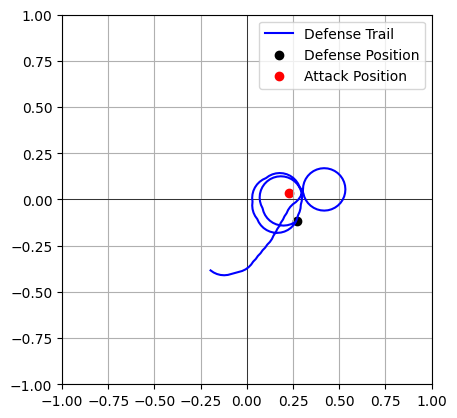

STEP REWARD:  -0.04568732331799817
EPISODE REWARD:  -0.04568732331799817
STEP REWARD:  0.1515748779058749
EPISODE REWARD:  0.10588755458787673
STEP REWARD:  0.3466228292780546
EPISODE REWARD:  0.45251038386593134
STEP REWARD:  0.5373384866176631
EPISODE REWARD:  0.9898488704835945
STEP REWARD:  0.7211848191228091
EPISODE REWARD:  1.7110336896064036
STEP REWARD:  0.8950371169161283
EPISODE REWARD:  2.6060708065225318
STEP REWARD:  1.0550120821932567
EPISODE REWARD:  3.6610828887157885
STEP REWARD:  1.196312634416486
EPISODE REWARD:  4.857395523132275
STEP REWARD:  1.3131242991520569
EPISODE REWARD:  6.170519822284332
STEP REWARD:  1.3466516998455196
EPISODE REWARD:  7.517171522129852
STEP REWARD:  1.381840656129105
EPISODE REWARD:  8.899012178258957
STEP REWARD:  1.4188089095712304
EPISODE REWARD:  10.317821087830188
STEP REWARD:  1.457684422093268
EPISODE REWARD:  11.775505509923455
STEP REWARD:  1.4986062951375876
EPISODE REWARD:  13.274111805061043
STEP REWARD:  1.5417257356825549
EP

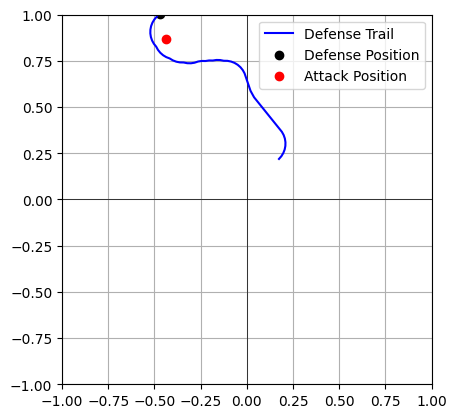

STEP REWARD:  -4.619567482342271
EPISODE REWARD:  -4.619567482342271
STEP REWARD:  -0.11087443854570611
EPISODE REWARD:  -4.730441920887977
STEP REWARD:  0.08193876258263708
EPISODE REWARD:  -4.64850315830534
STEP REWARD:  0.2730969465034892
EPISODE REWARD:  -4.375406211801851
STEP REWARD:  0.46054692103341643
EPISODE REWARD:  -3.914859290768434
STEP REWARD:  0.6418866429046812
EPISODE REWARD:  -3.272972647863753
STEP REWARD:  0.8142094041978533
EPISODE REWARD:  -2.4587632436658997
STEP REWARD:  0.9739463541427855
EPISODE REWARD:  -1.4848168895231142
STEP REWARD:  1.116721526494917
EPISODE REWARD:  -0.3680953630281971
STEP REWARD:  1.1372899068646354
EPISODE REWARD:  0.7691945438364383
STEP REWARD:  1.1582947520501352
EPISODE REWARD:  1.9274892958865735
STEP REWARD:  1.1797147191908859
EPISODE REWARD:  3.1072040150774596
STEP REWARD:  1.201520743680864
EPISODE REWARD:  4.3087247587583235
STEP REWARD:  1.223674484117397
EPISODE REWARD:  5.53239924287572
STEP REWARD:  1.3712723031120462


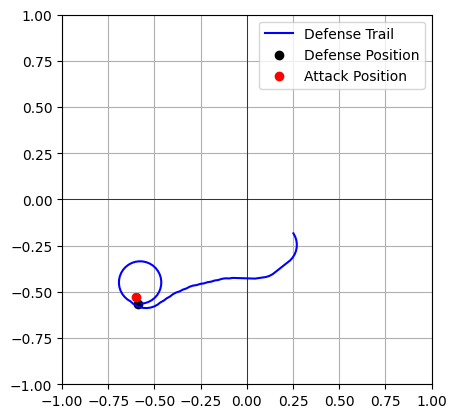

STEP REWARD:  -12.283172745600545
EPISODE REWARD:  -12.283172745600545
STEP REWARD:  -11.75545862935873
EPISODE REWARD:  -24.038631374959273
STEP REWARD:  -11.125484130124075
EPISODE REWARD:  -35.164115505083345
STEP REWARD:  -10.408437918296311
EPISODE REWARD:  -45.57255342337966
STEP REWARD:  -9.621030922406312
EPISODE REWARD:  -55.19358434578597
STEP REWARD:  -0.07940122892011497
EPISODE REWARD:  -55.272985574706084
STEP REWARD:  0.05772874099373121
EPISODE REWARD:  -55.21525683371235
STEP REWARD:  0.1920556117440484
EPISODE REWARD:  -55.02320122196831
STEP REWARD:  0.32141283101102563
EPISODE REWARD:  -54.70178839095728
STEP REWARD:  0.4434612999673394
EPISODE REWARD:  -54.258327090989944
STEP REWARD:  0.5556457359127845
EPISODE REWARD:  -53.70268135507716
STEP REWARD:  0.6551734210413745
EPISODE REWARD:  -53.047507934035785
STEP REWARD:  0.7390279803244008
EPISODE REWARD:  -52.308479953711384
STEP REWARD:  0.7489444967821532
EPISODE REWARD:  -51.55953545692923
STEP REWARD:  0.7590

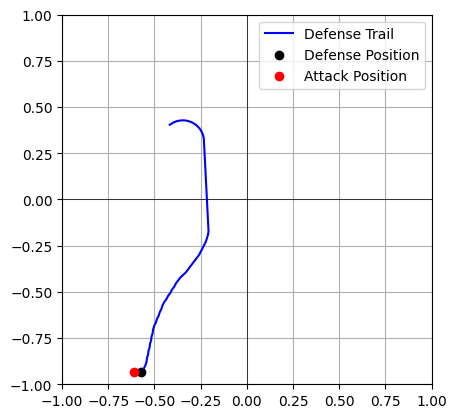

STEP REWARD:  1.3816036092176993
EPISODE REWARD:  1.3816036092176993
STEP REWARD:  1.4799620188982137
EPISODE REWARD:  2.8615656281159128
STEP REWARD:  1.5246510237681943
EPISODE REWARD:  4.386216651884107
STEP REWARD:  1.5721156726447616
EPISODE REWARD:  5.958332324528868
STEP REWARD:  1.6226215230398366
EPISODE REWARD:  7.580953847568705
STEP REWARD:  1.6764689527847167
EPISODE REWARD:  9.257422800353421
STEP REWARD:  1.7278371779255768
EPISODE REWARD:  10.985259978278998
STEP REWARD:  1.710606127203914
EPISODE REWARD:  12.695866105482912
STEP REWARD:  1.7676450985588095
EPISODE REWARD:  14.46351120404172
STEP REWARD:  1.6782766200687578
EPISODE REWARD:  16.14178782411048
STEP REWARD:  1.7234688815555612
EPISODE REWARD:  17.86525670566604
STEP REWARD:  1.5404375905469536
EPISODE REWARD:  19.405694296212996
STEP REWARD:  1.5588132557369194
EPISODE REWARD:  20.964507551949914
STEP REWARD:  1.574060241556246
EPISODE REWARD:  22.53856779350616
STEP REWARD:  1.5853871346535884
EPISODE REW

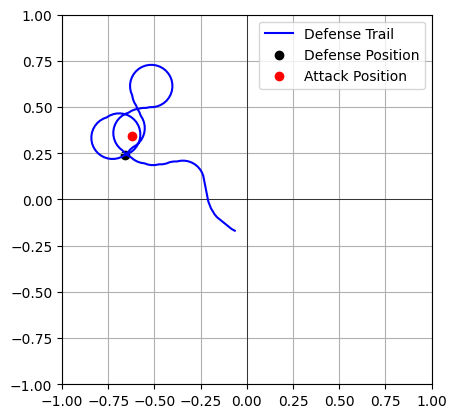

STEP REWARD:  -2.877063256734015
EPISODE REWARD:  -2.877063256734015
STEP REWARD:  -3.9629615187355256
EPISODE REWARD:  -6.840024775469541
STEP REWARD:  -4.718496596144939
EPISODE REWARD:  -11.558521371614479
STEP REWARD:  -4.408819356603584
EPISODE REWARD:  -15.967340728218062
STEP REWARD:  -4.058591945147015
EPISODE REWARD:  -20.025932673365077
STEP REWARD:  -3.6728388170458857
EPISODE REWARD:  -23.698771490410962
STEP REWARD:  -3.2557099451641665
EPISODE REWARD:  -26.95448143557513
STEP REWARD:  -2.810965024795762
EPISODE REWARD:  -29.765446460370892
STEP REWARD:  -2.342235351815305
EPISODE REWARD:  -32.1076818121862
STEP REWARD:  -1.8531697510504839
EPISODE REWARD:  -33.96085156323669
STEP REWARD:  -1.3475160906692498
EPISODE REWARD:  -35.30836765390594
STEP REWARD:  -0.8291647821134193
EPISODE REWARD:  -36.137532436019356
STEP REWARD:  -0.03168525891395434
EPISODE REWARD:  -36.16921769493331
STEP REWARD:  0.4239392545110921
EPISODE REWARD:  -35.74527844042222
STEP REWARD:  0.89200

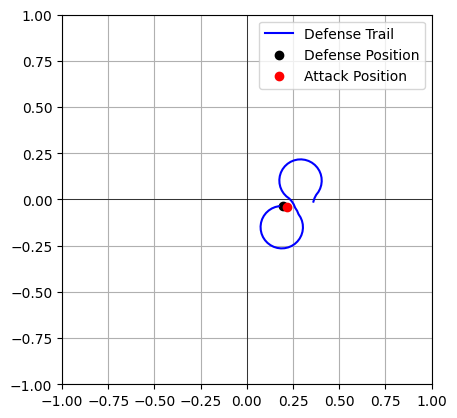

STEP REWARD:  0.8300052188704465
EPISODE REWARD:  0.8300052188704465
STEP REWARD:  0.9478587513274828
EPISODE REWARD:  1.7778639701979293
STEP REWARD:  0.9637333306496166
EPISODE REWARD:  2.741597300847546
STEP REWARD:  0.9799646315475851
EPISODE REWARD:  3.7215619323951312
STEP REWARD:  1.0830734480701327
EPISODE REWARD:  4.804635380465264
STEP REWARD:  1.1059123894741778
EPISODE REWARD:  5.910547769939441
STEP REWARD:  1.1296457528053445
EPISODE REWARD:  7.040193522744786
STEP REWARD:  1.1543209952017792
EPISODE REWARD:  8.194514517946565
STEP REWARD:  1.179988281644737
EPISODE REWARD:  9.374502799591303
STEP REWARD:  1.2067005618014133
EPISODE REWARD:  10.581203361392717
STEP REWARD:  1.2345136184750858
EPISODE REWARD:  11.815716979867803
STEP REWARD:  1.263486075684529
EPISODE REWARD:  13.079203055552332
STEP REWARD:  1.2936793506236444
EPISODE REWARD:  14.372882406175977
STEP REWARD:  1.3251575288453308
EPISODE REWARD:  15.698039935021308
STEP REWARD:  1.3579871356194915
EPISODE R

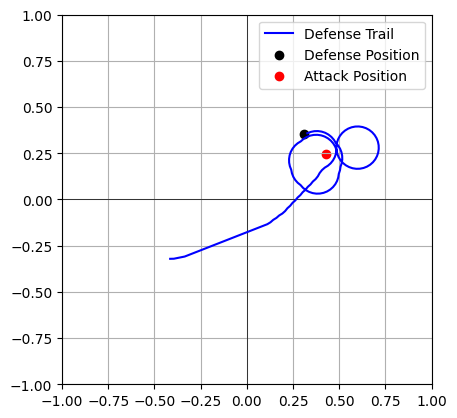

STEP REWARD:  0.21560996082334177
EPISODE REWARD:  0.21560996082334177
STEP REWARD:  0.333264971503005
EPISODE REWARD:  0.5488749323263468
STEP REWARD:  0.44270975499765575
EPISODE REWARD:  0.9915846873240025
STEP REWARD:  0.5414501722608878
EPISODE REWARD:  1.5330348595848902
STEP REWARD:  0.6268219663342087
EPISODE REWARD:  2.159856825919099
STEP REWARD:  0.6960347912854951
EPISODE REWARD:  2.855891617204594
STEP REWARD:  0.8499981741043857
EPISODE REWARD:  3.7058897913089797
STEP REWARD:  0.7473843703431281
EPISODE REWARD:  4.453274161652108
STEP REWARD:  0.7587519148535186
EPISODE REWARD:  5.2120260765056265
STEP REWARD:  0.7704661494575596
EPISODE REWARD:  5.9824922259631865
STEP REWARD:  0.7825430544587972
EPISODE REWARD:  6.7650352804219835
STEP REWARD:  0.7949995995947916
EPISODE REWARD:  7.560034880016775
STEP REWARD:  0.8078538211621458
EPISODE REWARD:  8.36788870117892
STEP REWARD:  0.8211249064040821
EPISODE REWARD:  9.189013607583002
STEP REWARD:  0.8348332859629062
EPISOD

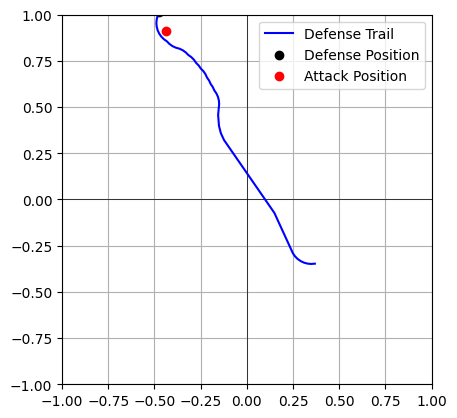

STEP REWARD:  1.2673212777115361
EPISODE REWARD:  1.2673212777115361
STEP REWARD:  1.396176259816841
EPISODE REWARD:  2.663497537528377
STEP REWARD:  1.5970400308205568
EPISODE REWARD:  4.2605375683489335
STEP REWARD:  1.5220115851087463
EPISODE REWARD:  5.78254915345768
STEP REWARD:  1.569359014905017
EPISODE REWARD:  7.351908168362697
STEP REWARD:  1.619700505854528
EPISODE REWARD:  8.971608674217226
STEP REWARD:  1.6733253922384002
EPISODE REWARD:  10.644934066455626
STEP REWARD:  1.7305609876933132
EPISODE REWARD:  12.375495054148939
STEP REWARD:  1.791778930619231
EPISODE REWARD:  14.167273984768169
STEP REWARD:  1.8574028235175204
EPISODE REWARD:  16.02467680828569
STEP REWARD:  1.9279174786882416
EPISODE REWARD:  17.95259428697393
STEP REWARD:  2.0038801698999205
EPISODE REWARD:  19.95647445687385
STEP REWARD:  2.224590255888612
EPISODE REWARD:  22.18106471276246
STEP REWARD:  2.1784324343882644
EPISODE REWARD:  24.359497147150723
STEP REWARD:  2.4190286774775496
EPISODE REWARD:

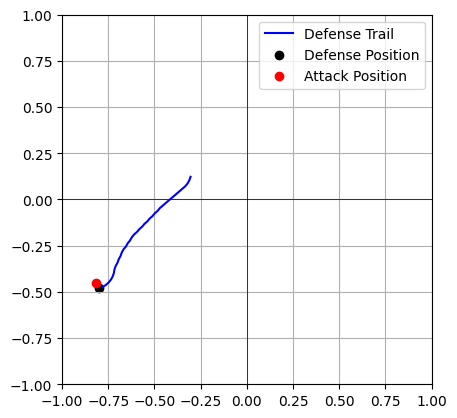

STEP REWARD:  -5.945272770598232
EPISODE REWARD:  -5.945272770598232
STEP REWARD:  -5.662498616451207
EPISODE REWARD:  -11.60777138704944
STEP REWARD:  -5.283421496030411
EPISODE REWARD:  -16.89119288307985
STEP REWARD:  -4.821213020910366
EPISODE REWARD:  -21.712405903990216
STEP REWARD:  -4.2879123533271075
EPISODE REWARD:  -26.000318257317325
STEP REWARD:  -3.6947750533825143
EPISODE REWARD:  -29.69509331069984
STEP REWARD:  -3.0525987755736077
EPISODE REWARD:  -32.747692086273446
STEP REWARD:  -2.3720058742605796
EPISODE REWARD:  -35.119697960534026
STEP REWARD:  -1.6636808027257932
EPISODE REWARD:  -36.78337876325982
STEP REWARD:  0.09615059269282157
EPISODE REWARD:  -36.687228170566996
STEP REWARD:  0.38092637709017263
EPISODE REWARD:  -36.30630179347683
STEP REWARD:  0.6669120638009478
EPISODE REWARD:  -35.63938972967588
STEP REWARD:  0.9535892288746423
EPISODE REWARD:  -34.685800500801236
STEP REWARD:  1.2398214589102836
EPISODE REWARD:  -33.44597904189095
STEP REWARD:  1.52349

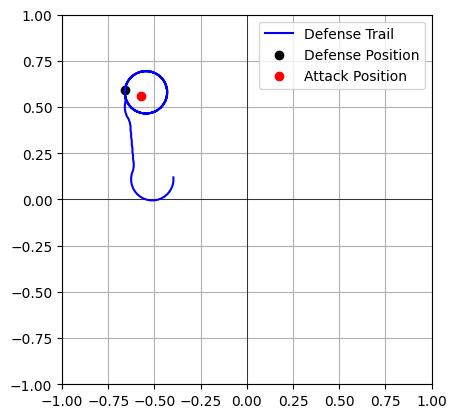

Average Reward: 901.2092249563673
Average Episode Length: 102.8
All Episodes Data:  {'Episode 1': {'past_defense_positions': [array([-0.19660394, -0.38372075]), array([-0.18014676, -0.39508566]), array([-0.1619661 , -0.40342015]), array([-0.14261438, -0.40847099]), array([-0.12267959, -0.4100847 ]), array([-0.10276744, -0.40821226]), array([-0.08348294, -0.40291055]), array([-0.06419844, -0.39760885]), array([-0.04491394, -0.39230714]), array([-0.02562944, -0.38700544]), array([-0.00755855, -0.37843556]), array([ 0.00874967, -0.3668579 ]), array([ 0.02279968, -0.35262423]), array([ 0.03416459, -0.33616705]), array([ 0.0482146 , -0.32193339]), array([ 0.05957952, -0.30547621]), array([ 0.07362953, -0.29124255]), array([ 0.08499444, -0.27478537]), array([ 0.09904446, -0.26055171]), array([ 0.11040937, -0.24409453]), array([ 0.12445938, -0.22986087]), array([ 0.13582429, -0.21340369]), array([ 0.14415879, -0.19522303]), array([ 0.1555237 , -0.17876585]), array([ 0.16385819, -0.1605852 ]),

In [67]:
import time
from copy import deepcopy  # Import deepcopy

model = DQN.load("dqn_missile_interception")


eval_env = missile_interception()

def graph(defense_positions, defense, attack):
    print("Plotting data:", defense_positions, defense, attack)  # Debug output
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    defense_xs, defense_ys = zip(*defense_positions)
    ax.plot(defense_xs, defense_ys, 'b-', label='Defense Trail')  
    ax.scatter(defense[0], defense[1], color='black', label='Defense Position')
    ax.scatter(attack[0], attack[1], color='red', label='Attack Position')

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

def just_trails(defense_positions):
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    if len(defense_positions) > 1:
        print("FUCKING TRUE")
        # Extracting x and y coordinates
        defense_xs, defense_ys = zip(*defense_positions)
        print("DEFENSE XS: ", defense_xs)
        print("DEFENSE YS: ", defense_ys)
        print("length defense xs:", len(defense_xs))
        print("length defense ys:", len(defense_ys))
        ax.scatter(defense_xs, defense_ys, color='black', label='Defense Trail')  # Black dots for defense trail
        ax.plot(defense_xs, defense_ys, 'b-', linewidth=2, label='Defense Trail')  # Blue line for defense trail

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# Function to plot the trail
def plot_defense_trail(defense_positions):
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    # Extracting x and y coordinates
    defense_xs, defense_ys = zip(*defense_positions)

    # turn into np.array
    defense_xs = np.array(defense_xs)
    defense_ys = np.array(defense_ys)

    print("defense_xs: ", defense_xs)
    print("defense_ys: ", defense_ys)

    # Plotting the trail
    ax.plot(defense_xs, defense_ys, 'b-', label='Defense Trail')  # Blue line for defense trail
    ax.scatter(defense_xs[-1], defense_ys[-1], color='red', s=100, label='Current Position')  # Current position

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# Number of evaluation episodes
n_eval_episodes = 10

# Lists to store results
episode_rewards = []
episode_lengths = []
interceptions = 0
out_of_bounds = 0
reached_max_steps = 0

all_episodes_data = {}

for i in range(n_eval_episodes):
    episode_data = {
        'past_defense_positions': [],
        'attack_positions': [],
        'defense_positions': [],
        'times': []
    }

    obs, _ = eval_env.reset()
    done = False
    episode_reward = 0
    episode_length = 0
    time_step = 0
    defense_positions = []  # Store defense positions for plotting

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        defense_positions.append(deepcopy(eval_env.defense))
        episode_data['past_defense_positions'].append(deepcopy(eval_env.defense))          
        obs, reward, done, _, info = eval_env.step(action)
        episode_data['defense_positions'].append(deepcopy(eval_env.defense))
        episode_data['attack_positions'].append(deepcopy(eval_env.attack))
        episode_data['times'].append(time_step * 0.02)

        episode_reward += reward
        print("STEP REWARD: ", reward)
        print("EPISODE REWARD: ", episode_reward)
        episode_length += 1

        # Update stats based on info dictionary if needed
        # interceptions += info.get('interceptions', 0)
        # out_of_bounds += info.get('out_of_bounds', 0)
        # reached_max_steps += info.get('reached_max_steps', 0)

        # Graph current and trail positions
        # graph(defense_positions, eval_env.defense, eval_env.attack)
        # just_trails(defense_positions)
        time_step += 1

    episode_key = f"Episode {i + 1}"  # Adding 1 to make it human-readable (1-indexed)
    all_episodes_data[episode_key] = episode_data

    # Store results
    graph(defense_positions, eval_env.defense, eval_env.attack)
    # just_trails(defense_positions)
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    # plot_defense_trail(defense_positions)

# Output averaged results or other statistics
print(f"Average Reward: {sum(episode_rewards) / len(episode_rewards)}")
print(f"Average Episode Length: {sum(episode_lengths) / len(episode_lengths)}")

print("All Episodes Data: ", all_episodes_data)

# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# def create_animation(episode_data, episode_index):
#     fig, ax = plt.subplots()
#     plt.xlim(-10, 10)
#     plt.ylim(-10, 10)
#     ax.set_aspect(1)
#     plt.grid(True)

#     defense_line, = ax.plot([], [], 'b-', label='Defense Trail')
#     attack_line, = ax.plot([], [], 'r-', label='Attack Trail')
#     defense_point, = ax.plot([], [], 'bo', label='Current Defense')
#     attack_point, = ax.plot([], [], 'ro', label='Current Attack')

#     def init():
#         defense_line.set_data([], [])
#         attack_line.set_data([], [])
#         defense_point.set_data([], [])
#         attack_point.set_data([], [])
#         return defense_line, attack_line, defense_point, attack_point

#     def update(frame):
#         defense_line.set_data(episode_data['defense_positions'][:frame], episode_data['times'][:frame])
#         attack_line.set_data(episode_data['attack_positions'][:frame], episode_data['times'][:frame])
        
#         defense_point.set_data(episode_data['defense_positions'][frame], episode_data['times'][frame])
#         attack_point.set_data(episode_data['attack_positions'][frame], episode_data['times'][frame])
        
#         return defense_line, attack_line, defense_point, attack_point

#     ani = FuncAnimation(fig, update, frames=len(episode_data['times']), init_func=init, blit=True, repeat=False)
#     plt.legend()

#     # Save or display the animation
#     ani.save(f"episode_{episode_index}.mp4", writer='ffmpeg')  # Save as video
#     # plt.show()  # Or display it interactively



    


# def graph(trajectory_data):
#     fig, ax = plt.subplots()
#     plt.xlim(-1, 1)
#     plt.ylim(-1, 1)
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(0, color='black', linewidth=0.5)
#     plt.grid(True)

#     # Plot trajectories
#     for trail in trajectory_data:
#         defense_xs, defense_ys = zip(*trail['defense_positions'])
#         attack_xs, attack_ys = zip(*trail['attack_positions'])
#         ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense
#         ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack
#         plt.scatter(defense_xs[-1], defense_ys[-1], color='black')  # Current defense position
#         plt.scatter(attack_xs[-1], attack_ys[-1], color='red')  # Current attack position

#     plt.show()

# for i in range(n_eval_episodes):
#     obs, _ = eval_env.reset()
#     done = False
#     episode_reward = 0
#     episode_length = 0
#     trajectories = {'defense_positions': [], 'attack_positions': []}  # Store trajectories
    
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, _, info = eval_env.step(action)
#         env.graph(eval_env.defense, eval_env.attack)
#         trajectories['defense_positions'].append(tuple(eval_env.defense))
#         trajectories['attack_positions'].append(tuple(eval_env.attack))
#         episode_reward += reward
#         episode_length += 1
        
    
#     episode_rewards.append(episode_reward)
#     episode_lengths.append(episode_length)
#     interceptions += eval_env.interceptions
#     out_of_bounds += eval_env.out_of_bounds
#     reached_max_steps += eval_env.reached_max_steps
#     graph(trajectories)

# # Calculate average metrics
# avg_reward = np.mean(episode_rewards)
# avg_length = np.mean(episode_lengths)
# success_rate = interceptions / n_eval_episodes
# out_of_bounds_rate = out_of_bounds / n_eval_episodes
# max_steps_rate = reached_max_steps / n_eval_episodes

# print(f"Average Reward: {avg_reward:.2f}")
# print(f"Average Episode Length: {avg_length:.2f}")
# print(f"Success Rate: {success_rate:.2%}")
# print(f"Out of Bounds Rate: {out_of_bounds_rate:.2%}")
# print(f"Reached Max Steps Rate: {max_steps_rate:.2%}")

In [65]:
print("All Episodes Data: ", all_episodes_data)
print(type(all_episodes_data))

# 

All Episodes Data:  {'Episode 1': {'past_defense_positions': [array([ 0.30016461, -0.11128399]), array([ 0.30792881, -0.09285257]), array([ 0.31569302, -0.07442116]), array([ 0.32345722, -0.05598974]), array([ 0.33122143, -0.03755832]), array([ 0.33898563, -0.01912691]), array([ 0.34674984, -0.00069549]), array([0.35451404, 0.01773593]), array([0.36227825, 0.03616735]), array([0.37004245, 0.05459876]), array([0.37780665, 0.07303018]), array([0.38557086, 0.0914616 ]), array([0.39641769, 0.10826476]), array([0.40726452, 0.12506792]), array([0.4208644 , 0.13973227]), array([0.43680411, 0.15181225]), array([0.45274382, 0.16389222]), array([0.47053903, 0.17302077]), array([0.48833424, 0.18214932]), array([0.50612945, 0.19127787]), array([0.52392467, 0.20040642]), array([0.54303468, 0.20630618]), array([0.5621447 , 0.21220594]), array([0.57993992, 0.22133449]), array([0.59773513, 0.23046304]), array([0.61367483, 0.24254301]), array([0.63147005, 0.25167156]), array([0.64740975, 0.26375153]), 

In [ ]:
# import gymnasium as gym
# from stable_baselines3 import DQN, PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# env = DummyVecEnv([lambda: missile_interception()])

# summary_writer = tf.summary.create_file_writer('./dqn_missile_interception_logs')

# def run_episode(env):
#     with summary_writer.as_default():
#         for step in range(env.max_steps):
#             ...
#             tf.summary.scalar('Reward', reward, step=total_steps)
#             if done:
#                 tf.summary.scalar('Episode Length', step + 1, step=episode)
#                 break
#         tf.summary.scalar('Out of Bounds Count', env.out_of_bounds, step=episode)
#         tf.summary.scalar('Interceptions Count', env.interceptions, step=episode)
#         tf.summary.scalar('Reached Max Steps Count', env.reached_max_steps, step=episode)

# model = DQN("MlpPolicy", env, tensorboard_log="./dqn_missile_interception_logs", verbose=1)
# model.learn(total_timesteps=1000000)
# model.save("updated_missile_guidance")
# env.close()

In [ ]:
# # import gymnasium as gym
# import numpy as np
# import matplotlib.pyplot as plt
# import random
# import math
# import tensorflow as tf
# import datetime

# # Assuming missile_interception is already defined and imported

# def run_episodes(num_episodes, max_steps_per_episode):
#     # Initialize variables for tracking statistics
#     episode_lengths = []
#     hits = 0  # Track the number of successful hits

#     # Run multiple episodes
#     for episode in range(num_episodes):
#         # Reset the environment at the start of each episode
#         env = missile_interception()
#         _, _ = env.reset()
        
#         print("----------------------------------------------------------")
#         print(f"STARTING EPISODE {episode + 1}")
#         print("----------------------------------------------------------")
        
#         # Run the simulation for up to max_steps_per_episode or until the episode ends
#         for step in range(max_steps_per_episode):
#             # Choose a random action
#             action = random.choice([0, 1, 2])
#             # actions = [random.choice([0, 1, 2]) for _ in range(num_steps)]
            
#             # Take the action and observe the outcome
#             state, reward, done, truncated, _ = env.step(action)

#             # Check if a hit has occurred, typically by checking reward or state
#             if reward > 90:  # Assuming reward > 90 indicates a hit
#                 hits += 1
#                 print(f"Hit! Missile successfully intercepted the target at step {step + 1} of episode {episode + 1}.")

#             if done:
#                 # If the episode has ended, record the length
#                 episode_lengths.append(step + 1)
#                 print(f"Episode {episode + 1} ended after {step + 1} steps.")
#                 break
#         else:
#             # If not done after max steps, consider it a full length episode
#             episode_lengths.append(max_steps_per_episode)
    
#     # Calculate the average episode length
#     average_length = np.mean(episode_lengths)
#     return average_length, episode_lengths, hits

# # Parameters
# num_episodes = 100
# max_steps_per_episode = 150

# # Run the simulations
# average_length, episode_lengths, total_hits = run_episodes(num_episodes, max_steps_per_episode)

# print("----------------------------------------------------------")
# print(f"Average episode length over {num_episodes} episodes: {average_length:.2f} steps")
# print(f"Total hits across all episodes: {total_hits}")
# print("----------------------------------------------------------")
